In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pickle

font = {
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]
plt.rcParams['figure.dpi'] = 300

# For 1 setting (Task exp): ~50k steps per minutes (for each agent process)

N_TASKS = 200 #Actual: 60
N_ARMS = 5
OPT_SIZE = 2 # >1
HORIZON = 100
N_EXPS = 2 #No. of repeat experiments

# N_TASKS = 500 #Actual: 60
# N_ARMS = 80
# OPT_SIZE = 8 # >1
# HORIZON = 4000
# N_EXPS = 5 #No. of repeat experiments

GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD*1.1)
kwargs = {
          'gap_constrain':gap,
          'is_adversarial': True,
#           'skip_list': ["PMML", "GML", "GML_FC", "EE"],
#           'skip_list': [],
          'skip_list': ['PMML', 'GML_FC',],
          'timeout': 45, # maximum duration for each experiment. Unit = minute. -1 = unlimited
          'quiet': True,
          'linewidth': 4,
          'plot_legend': False,
          'OG_scale': 0.08,
#           'OG_scale': 0.008,
          'n_optimal': 1,
         }
if kwargs['is_adversarial']:
    setting = "Adversarial"
else:
    setting = "Stochastic"
assert N_ARMS<=HORIZON, f"The number of arm ({N_ARMS}) must be smaller than the horizon ({HORIZON})"
assert OPT_SIZE<=N_ARMS, f"The subset size ({OPT_SIZE}) must be smaller than the number of arm ({N_ARMS})"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')

PE_params = 4*np.log(max(np.exp(1), N_ARMS*HORIZON/4))
if N_ARMS*PE_params > HORIZON:
    print(f"WARNING (Phased Elimination): phase 1 duration ({N_ARMS*PE_params}) is larger than the horizon ({HORIZON}) \n=> increase horizon and/or change n_arms.")
og_lambda = kwargs['OG_scale']*OPT_SIZE*(1+np.log(N_TASKS))*(N_ARMS*np.log(N_ARMS)/N_TASKS)**(1/3)
if og_lambda<0 or og_lambda>1:
    print(f"WARNING (OG baseline): og_lambda ({og_lambda}) must in range [0,1]. Decrease # of arms and subset size or Increase # of task")
print(f"og_lambda = {og_lambda}")

B_TK = np.sqrt(HORIZON * N_ARMS * np.log(N_ARMS))
p = np.sqrt((OPT_SIZE*HORIZON)/(N_TASKS*B_TK))
print(f"GML EXR prob = {p}")

GAP_THRESHOLD = 0.5146997846583985, actual gap = 0.5661697631242384
og_lambda = 0.01726576953474
GML EXR prob = 0.18775388926286424


## Regret vs Number of tasks

100%|██████████| 2/2 [00:00<00:00, 318.70it/s]

opt_indices = [2 3]
opt_indices = [0 1]


opt_indices = [1 3]opt_indices = [0 2]



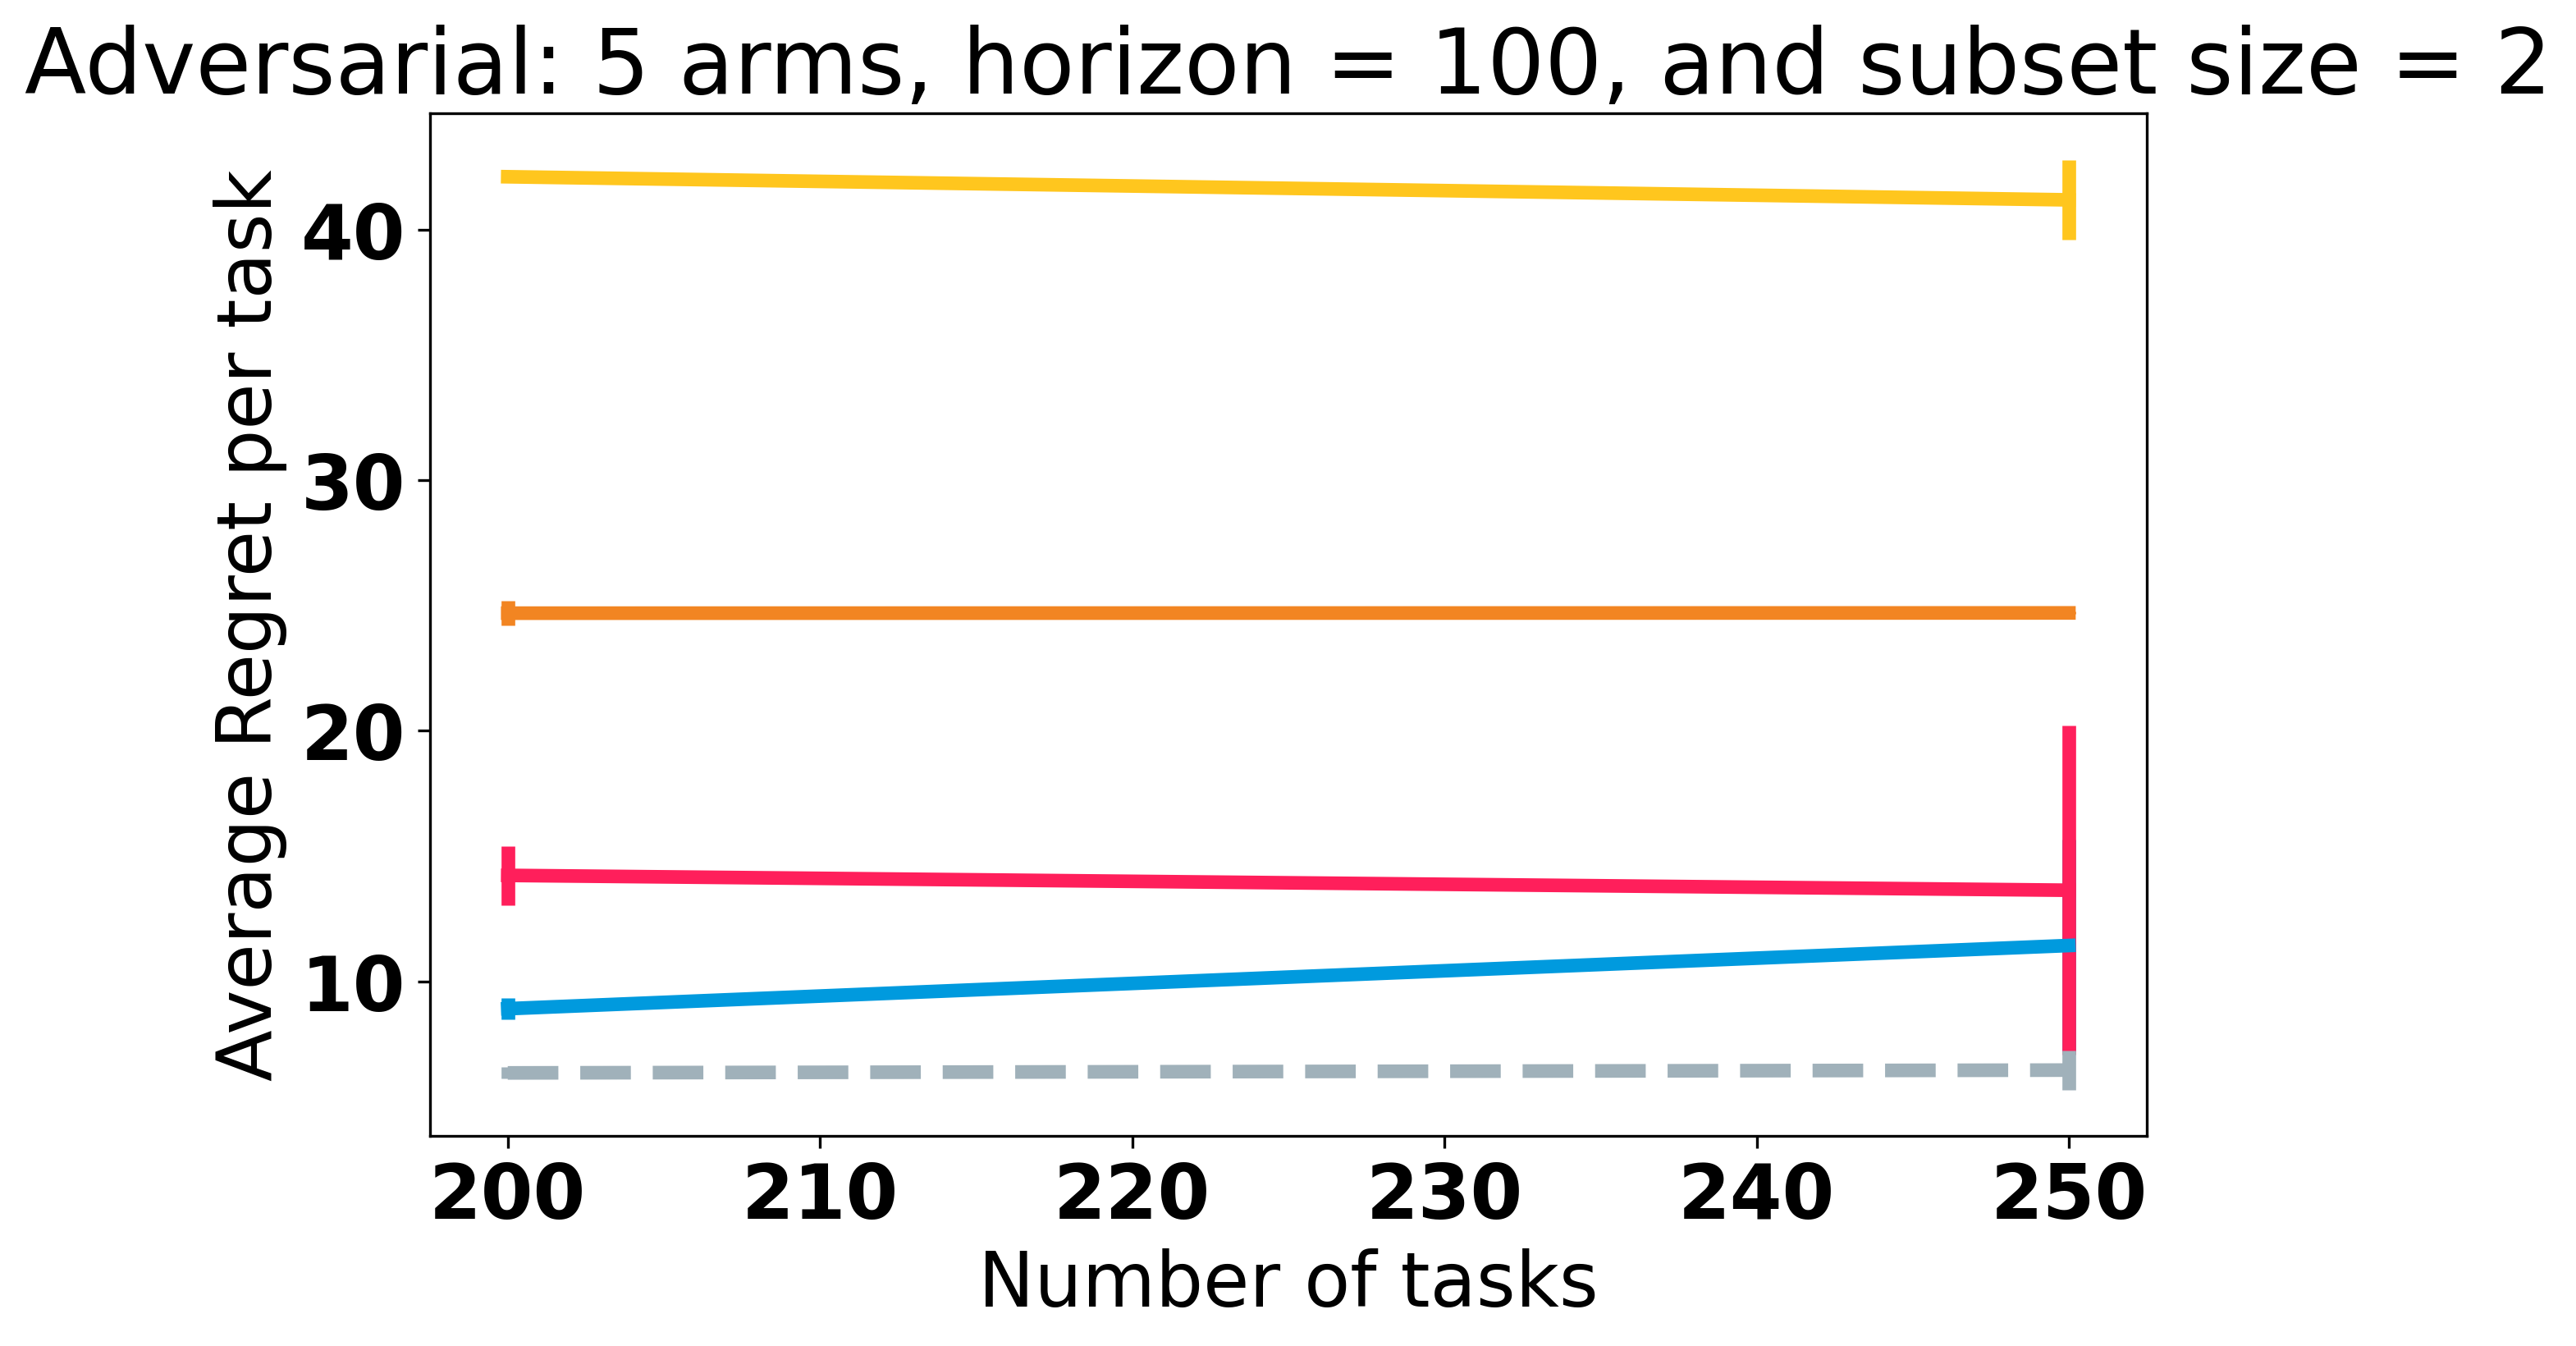

In [2]:
task_list = np.arange(200, 251, 50)
# task_list = np.arange(200, 1001, 200)
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, HORIZON, N_ARMS, OPT_SIZE, task_list, **kwargs)
# pickle.dump(regret_dict, open("results/tasks.p", "wb"))
# regret_dict = pickle.load(open("results/tasks.p", "rb"))
pass

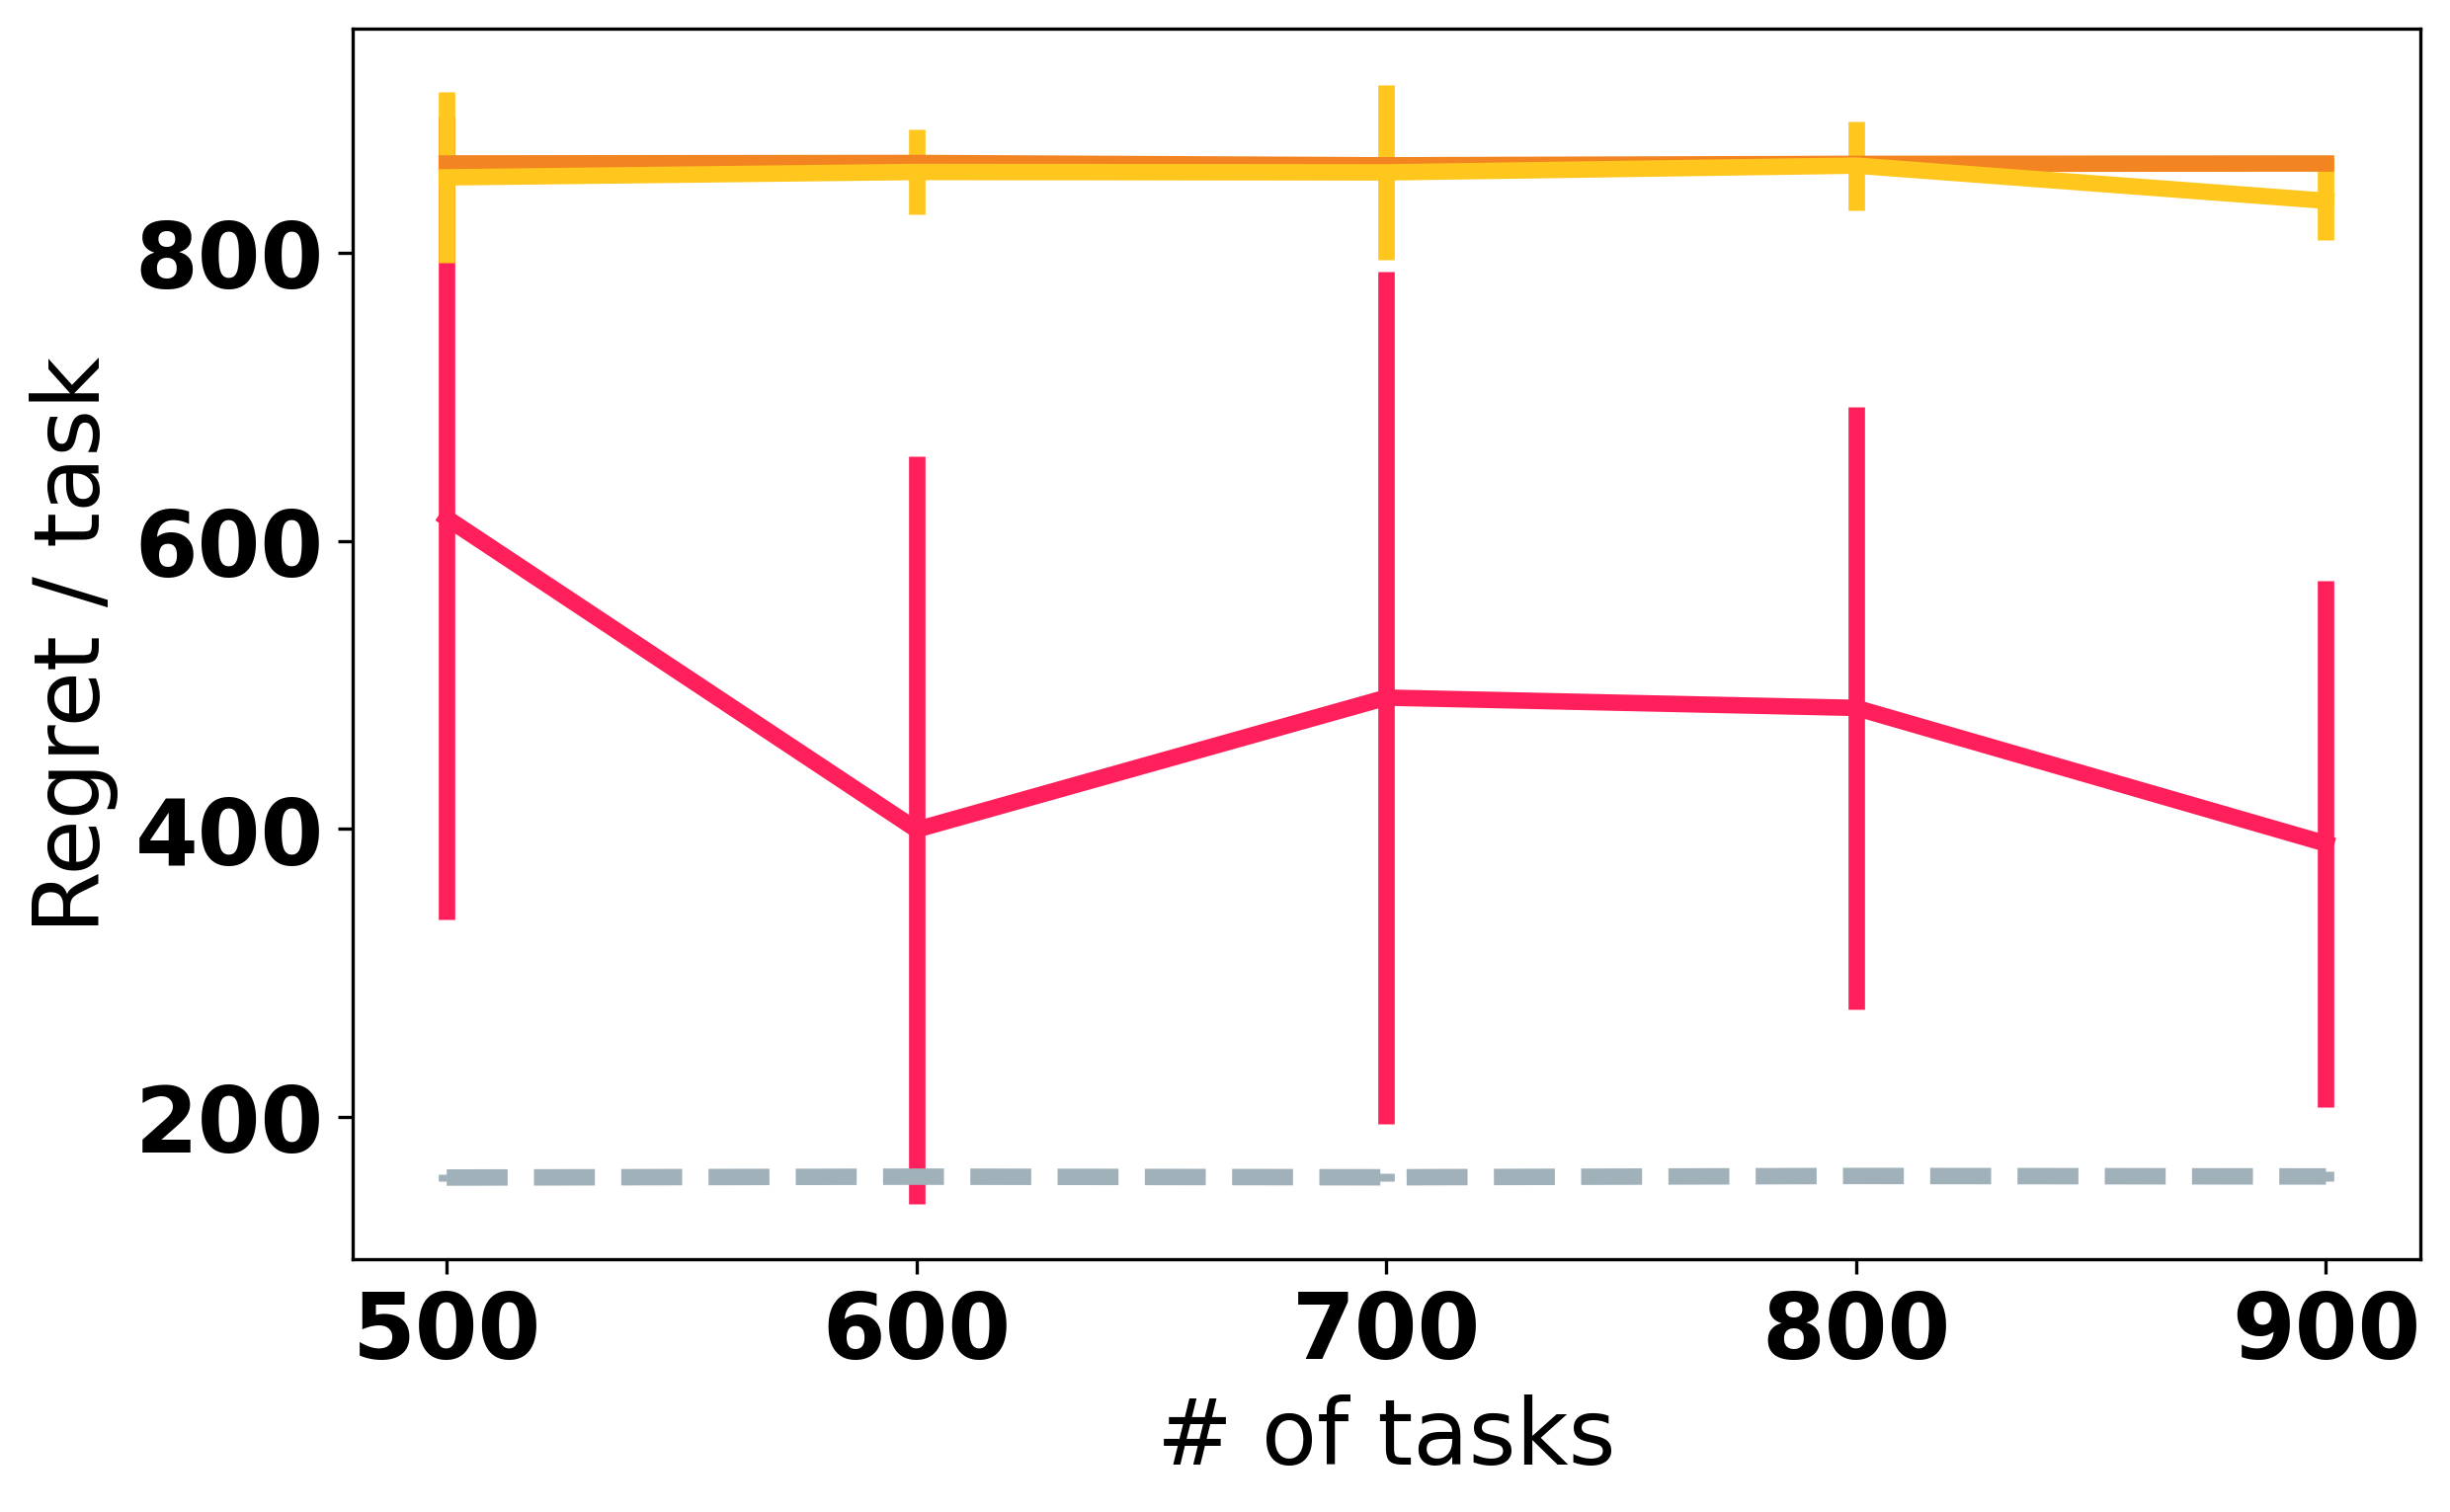

In [51]:
# Plot from loaded cache file
# X = np.arange(N_TASKS)
X = np.arange(500,910,100)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/cache_600_tasks/Adversarial_tasks.p", "rb"))
# regret_dict = pickle.load(open("results/Adversarial2_tasks.p", "rb"))
title = ''
# title = f'{setting}:{N_ARMS} arms, horizon = {HORIZON}, and subset size = {OPT_SIZE}'
xlabel, ylabel = '# of tasks', 'Regret / task'
# plt.ylim([-5, 2000])
utils.plot(X, regret_dict, title, xlabel, ylabel, **kwargs)
pass

## Regret vs Horizon

100%|██████████| 2/2 [00:00<00:00, 334.06it/s]

opt_indices = [3 4]
opt_indices = [3 4]


opt_indices = [0 2]
opt_indices = [2 4]


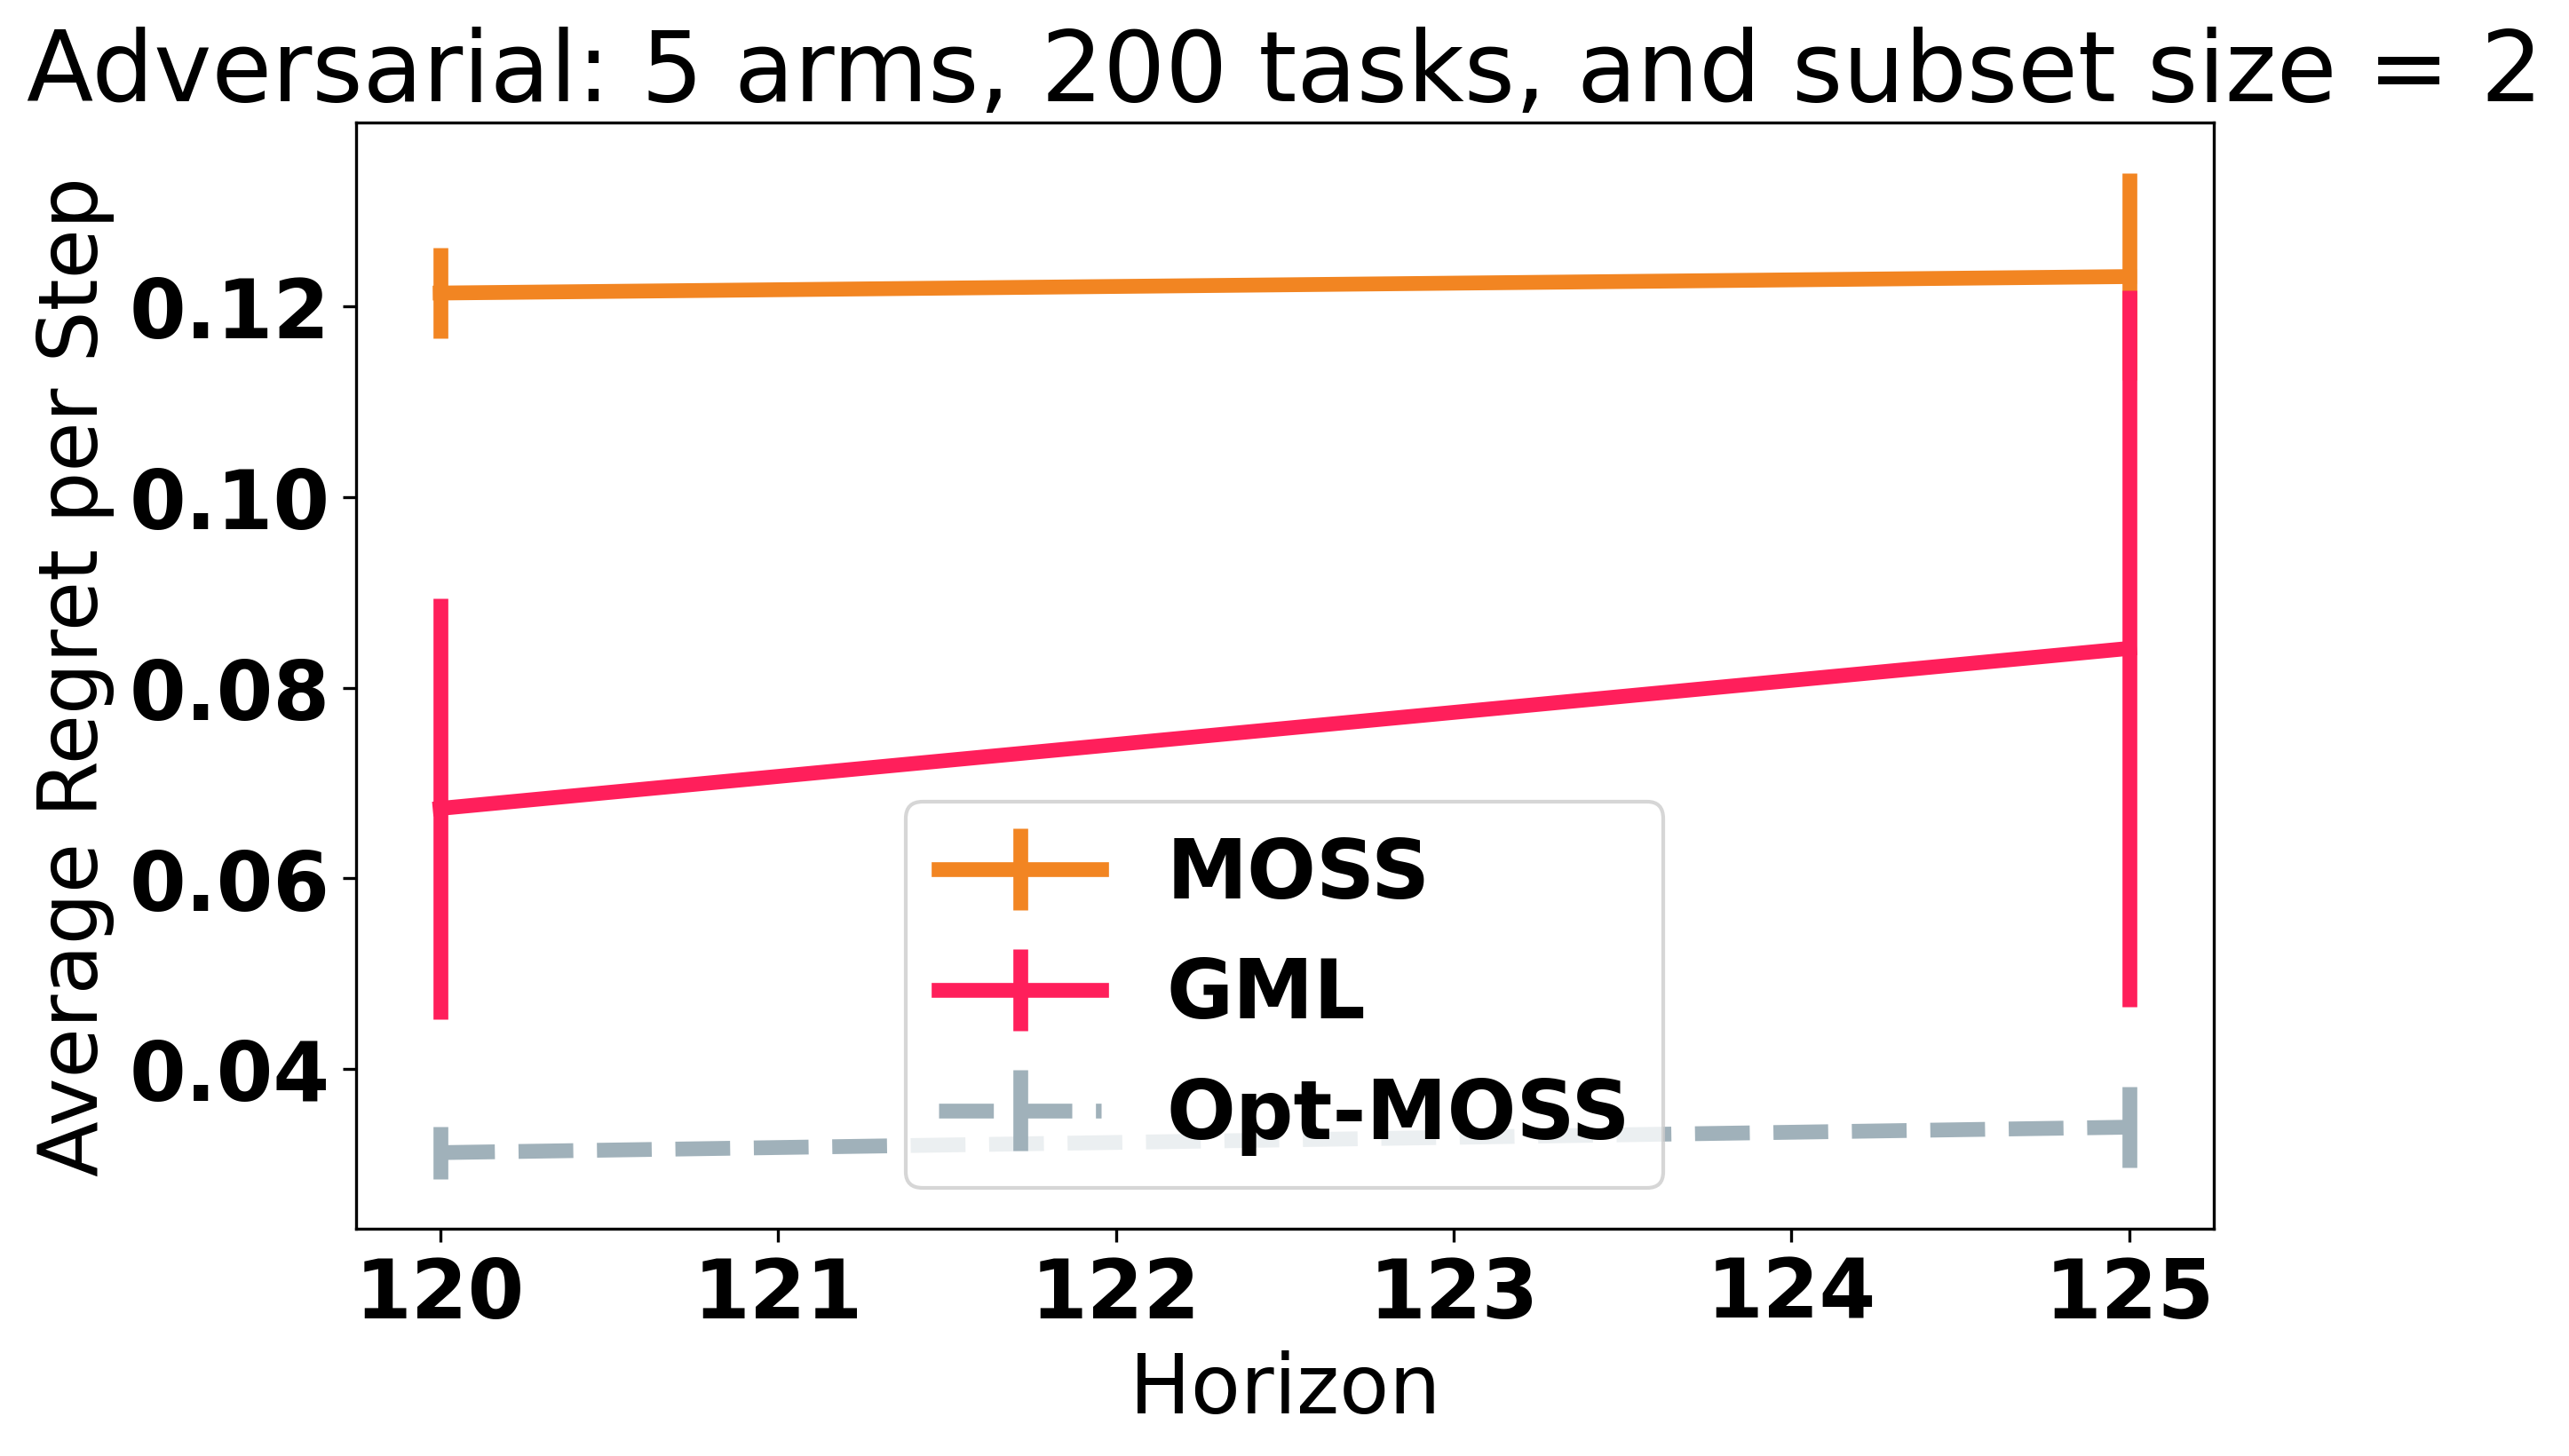

In [3]:
horizon_list = np.arange(120, 126, 5)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
# pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
# regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
pass

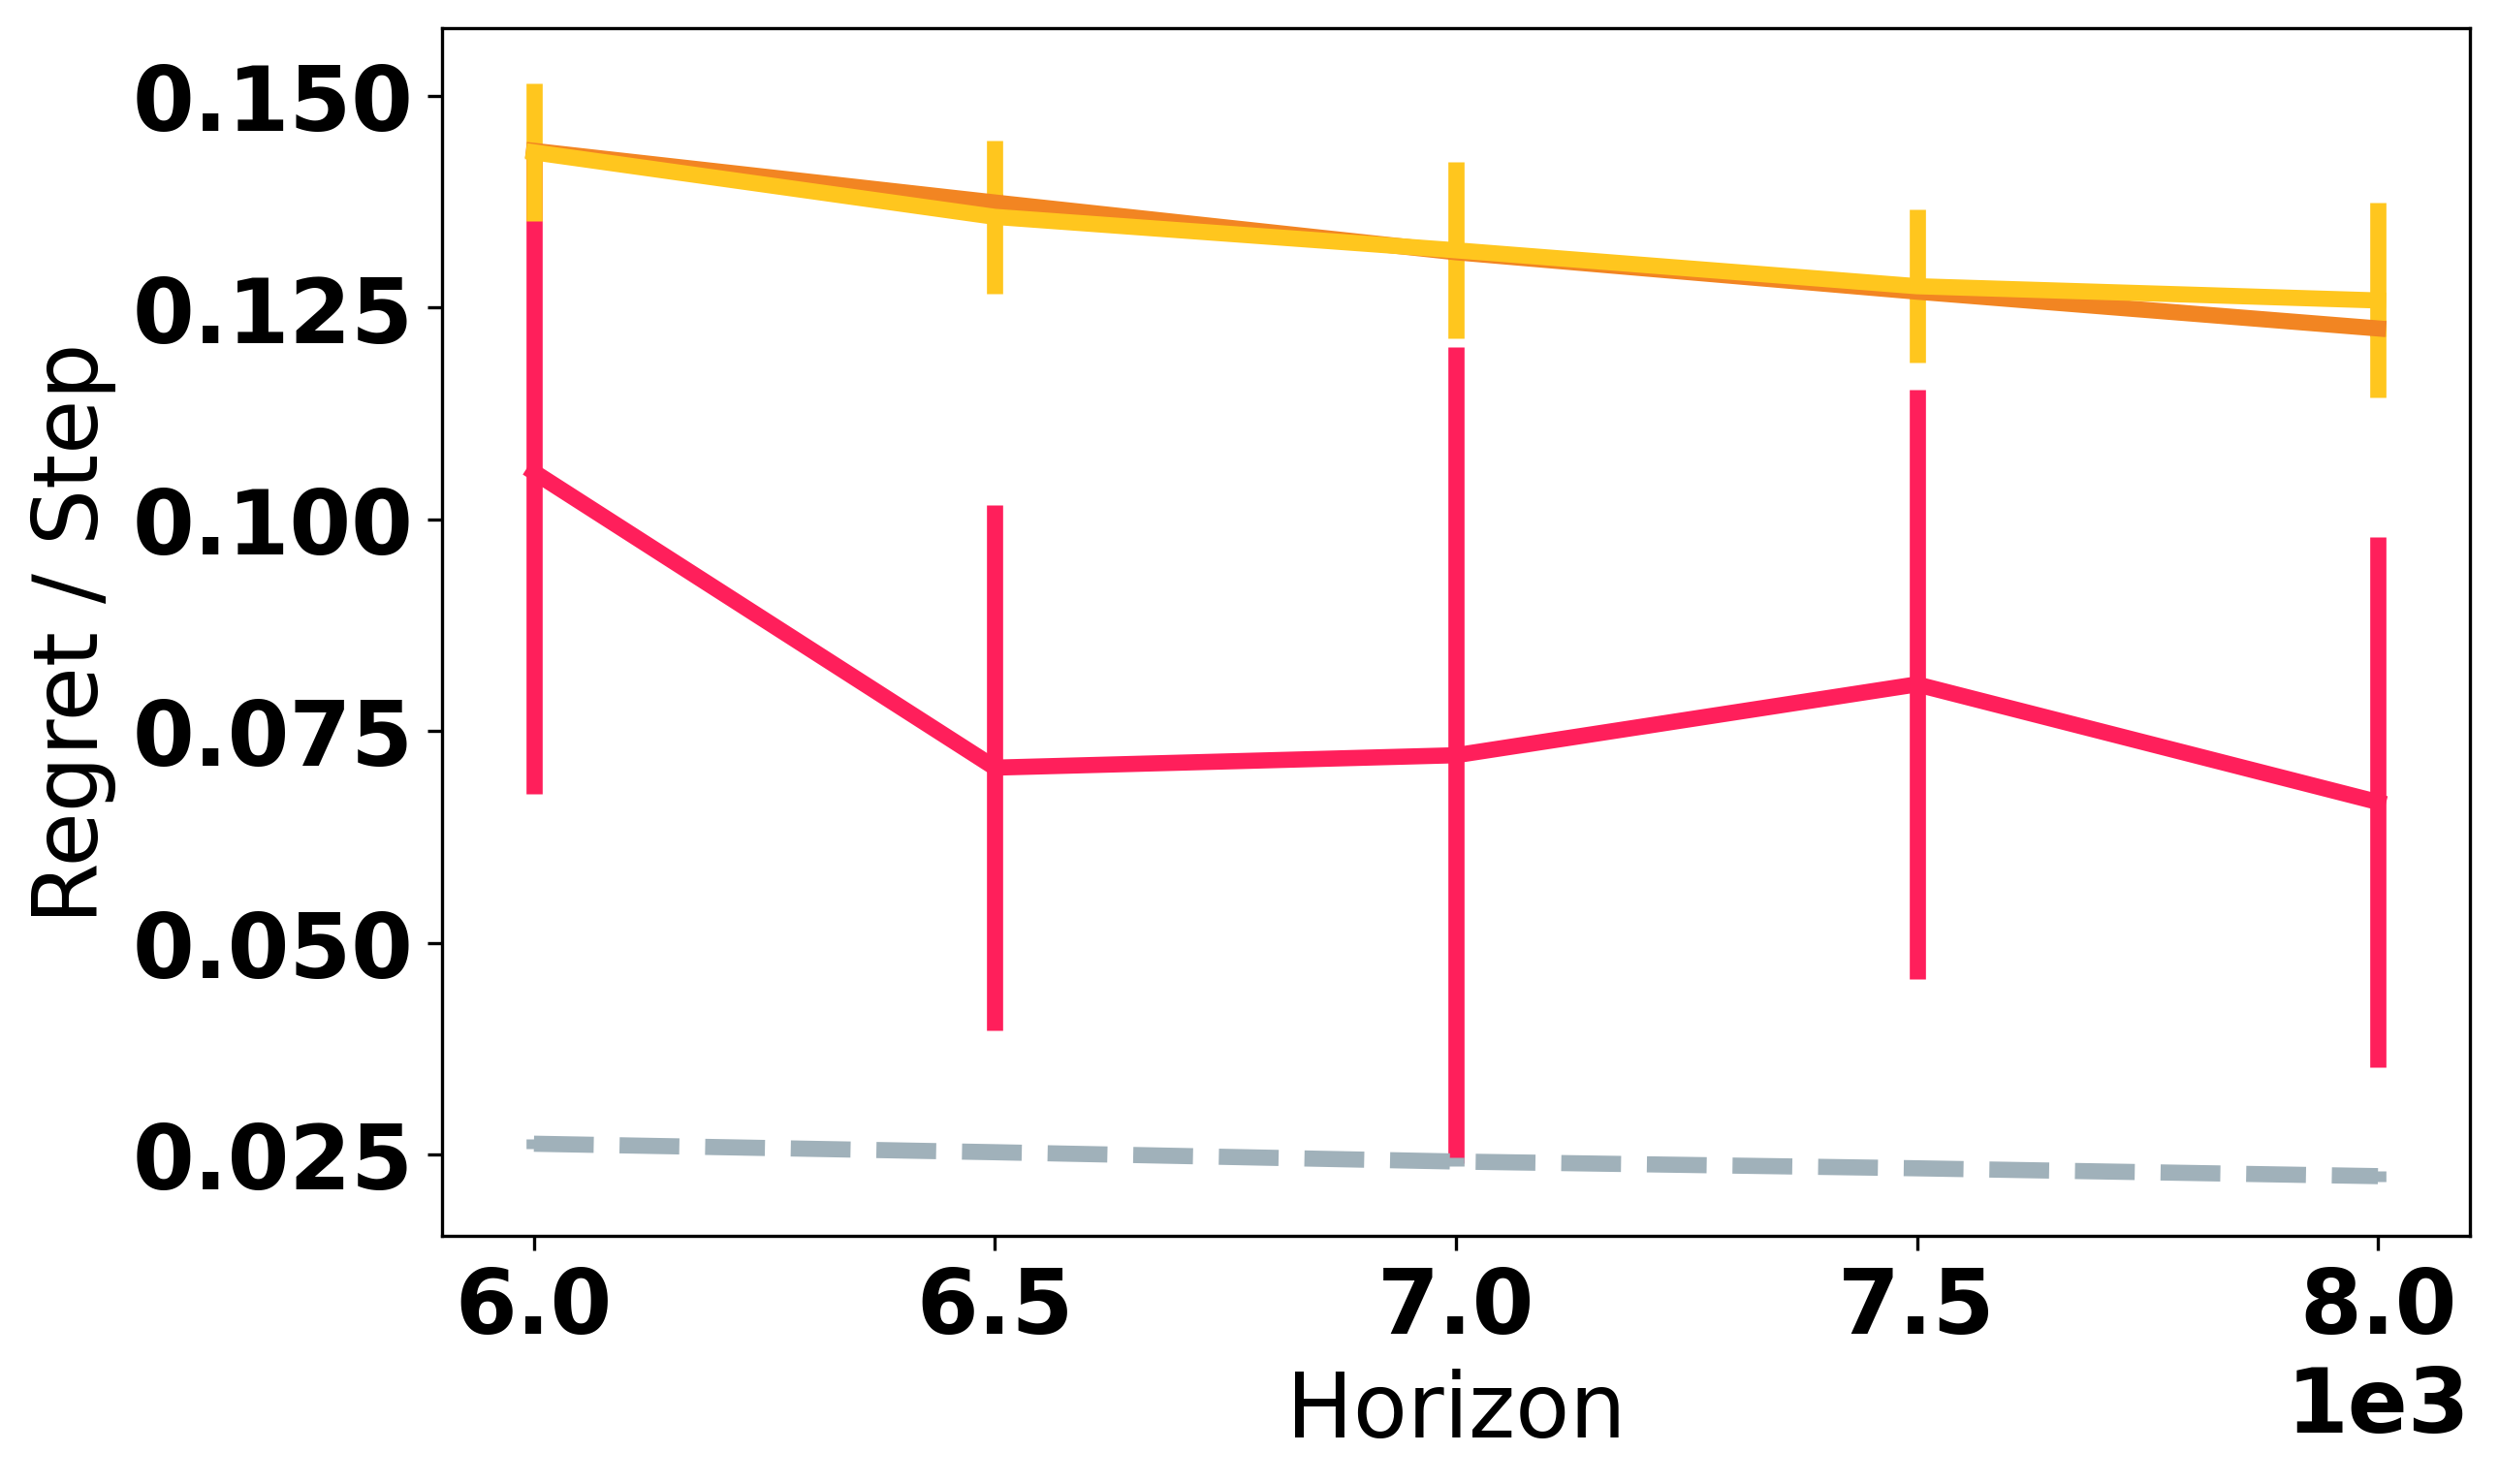

In [52]:
# Plot from loaded cache file
# X_h = np.arange(120, 260, 25) # small
# X_h = np.arange(270, 440, 50) # small stochastic
X_h = np.arange(6000, 8010, 500)
regret_dict_h = pickle.load(open("results/cache_600_tasks/Adversarial_horizon.p", "rb"))
# regret_dict_h = pickle.load(open("results/Adversarial2_horizon.p", "rb"))
title = ''
# title = f'{setting}: {N_ARMS} arms, {N_TASKS} tasks, and subset size = {OPT_SIZE}'
xlabel, ylabel = 'Horizon', 'Regret / Step'
# plt.ylim([-0.4, 0.6])
utils.plot(X_h, regret_dict_h, title, xlabel, ylabel, **kwargs)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Regret vs # of arm

100%|██████████| 2/2 [00:00<00:00, 232.78it/s]

opt_indices = [0 1]
opt_indices = [0 1]


opt_indices = [1 3]
opt_indices = [1 2]
opt_indices = [2 3]
opt_indices = [0 1]
opt_indices = [4 5]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [2 3]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [2 4]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [1 3]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.


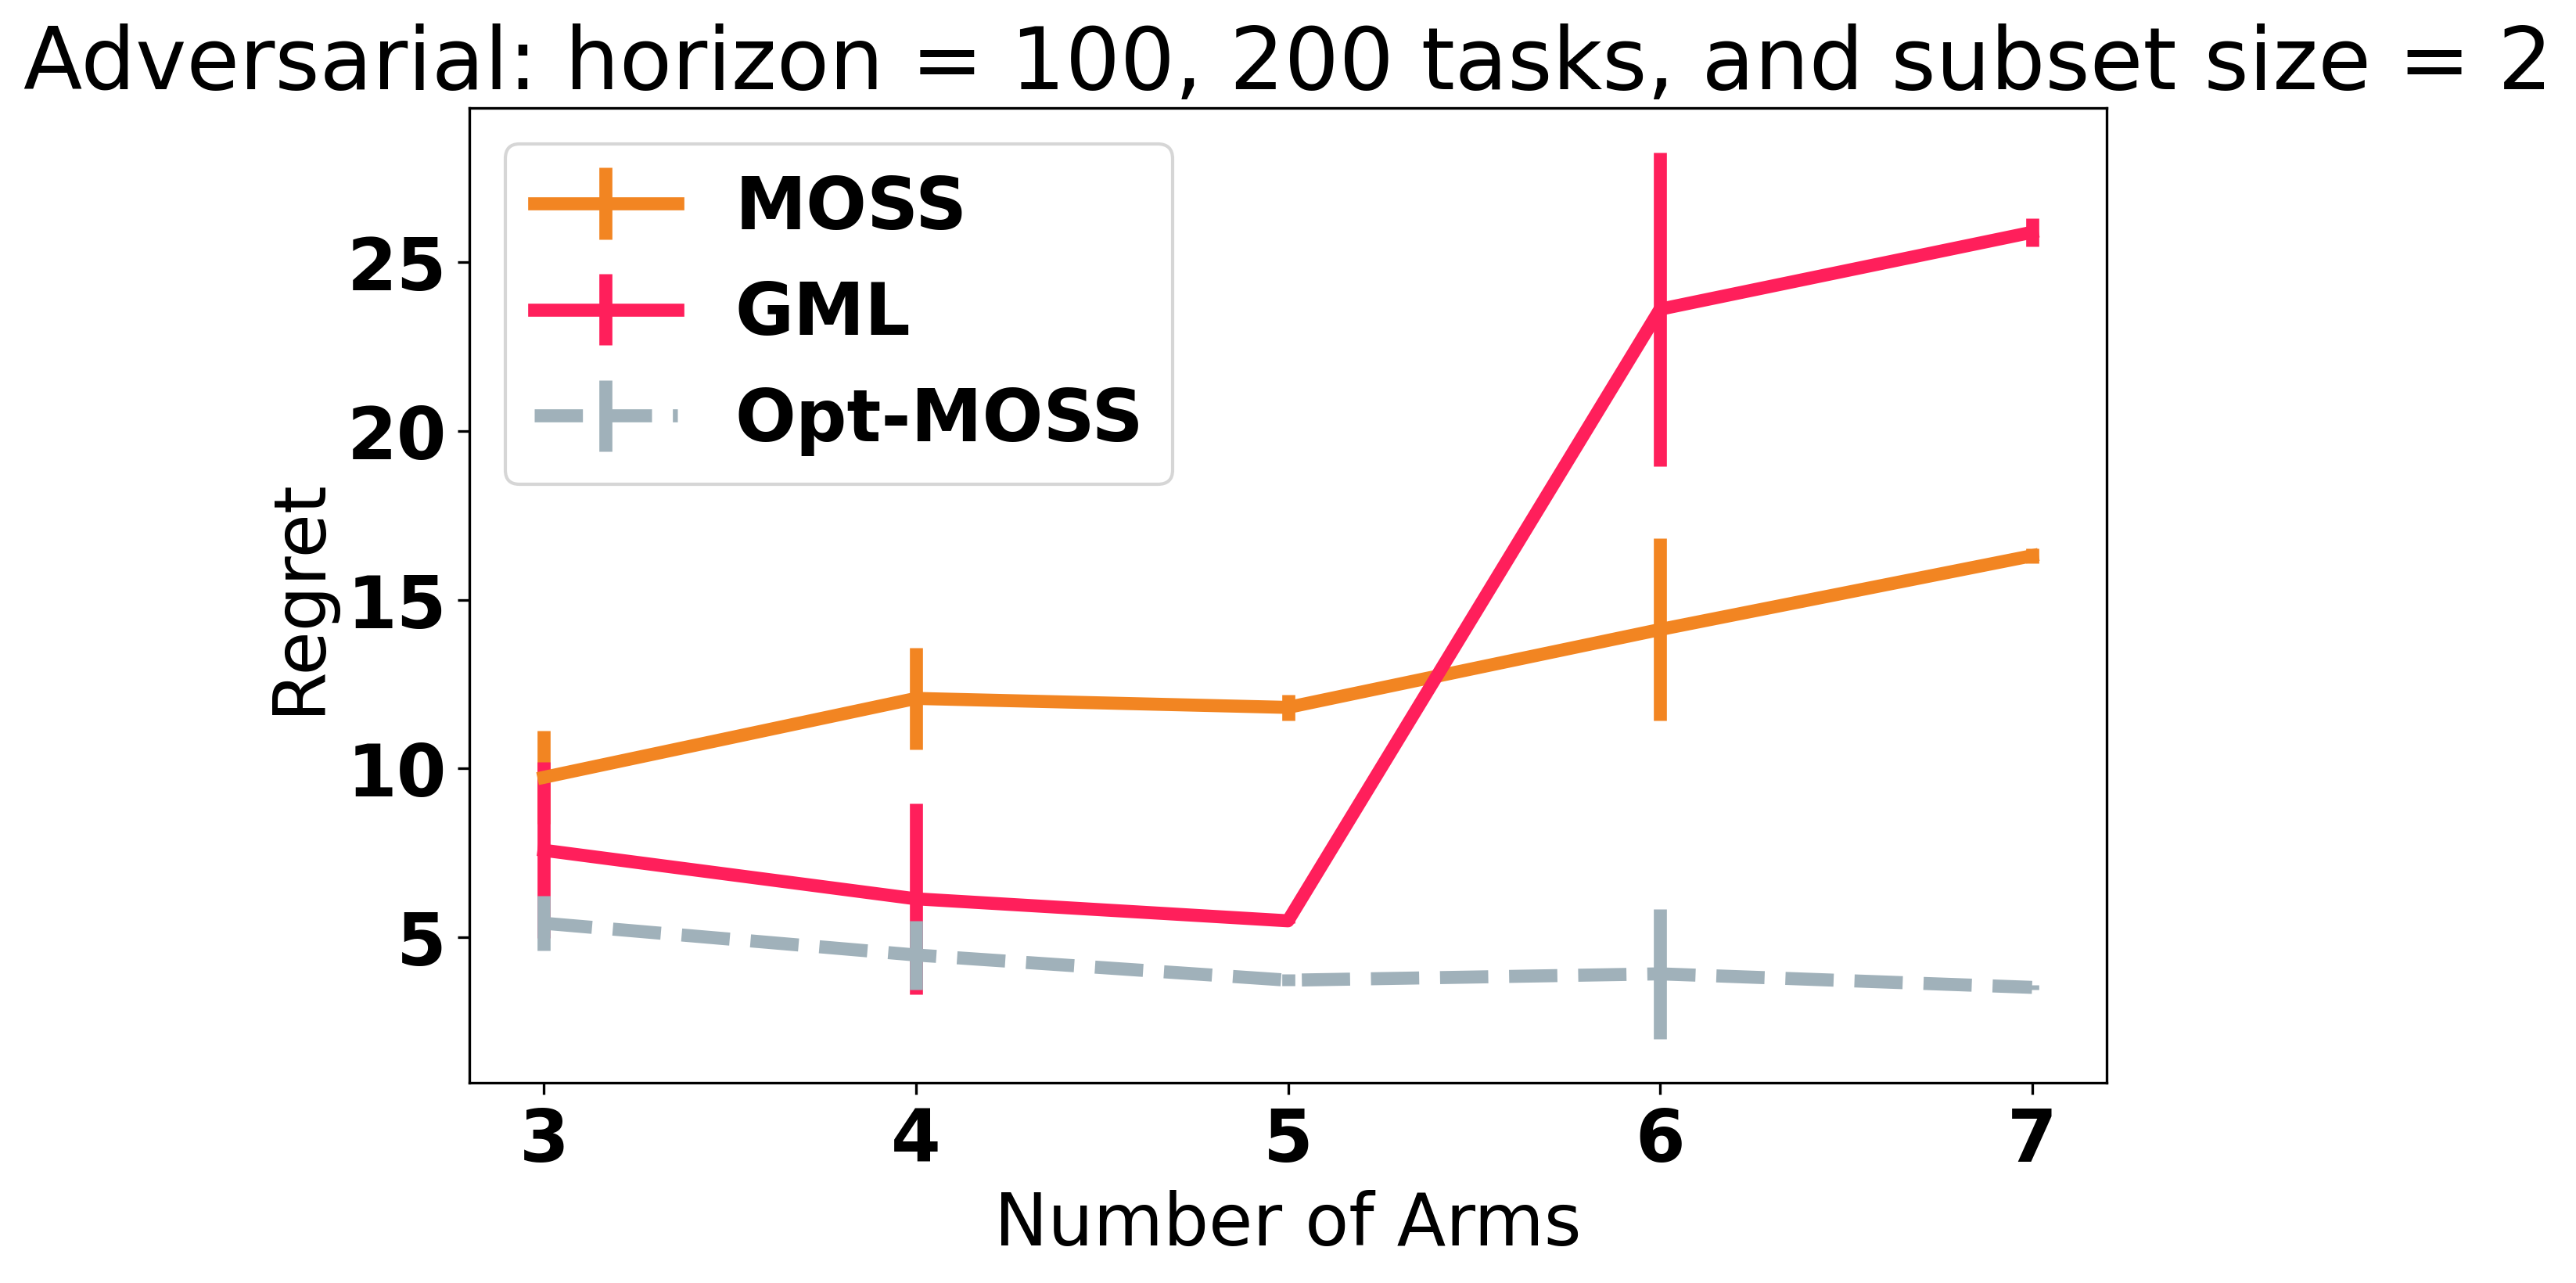

In [4]:
n_arms_list = np.arange(3,8,1)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, HORIZON, OPT_SIZE, n_arms_list, **kwargs)
# pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
# regret_dict_h = pickle.load(open("results/arms.p", "rb"))
pass

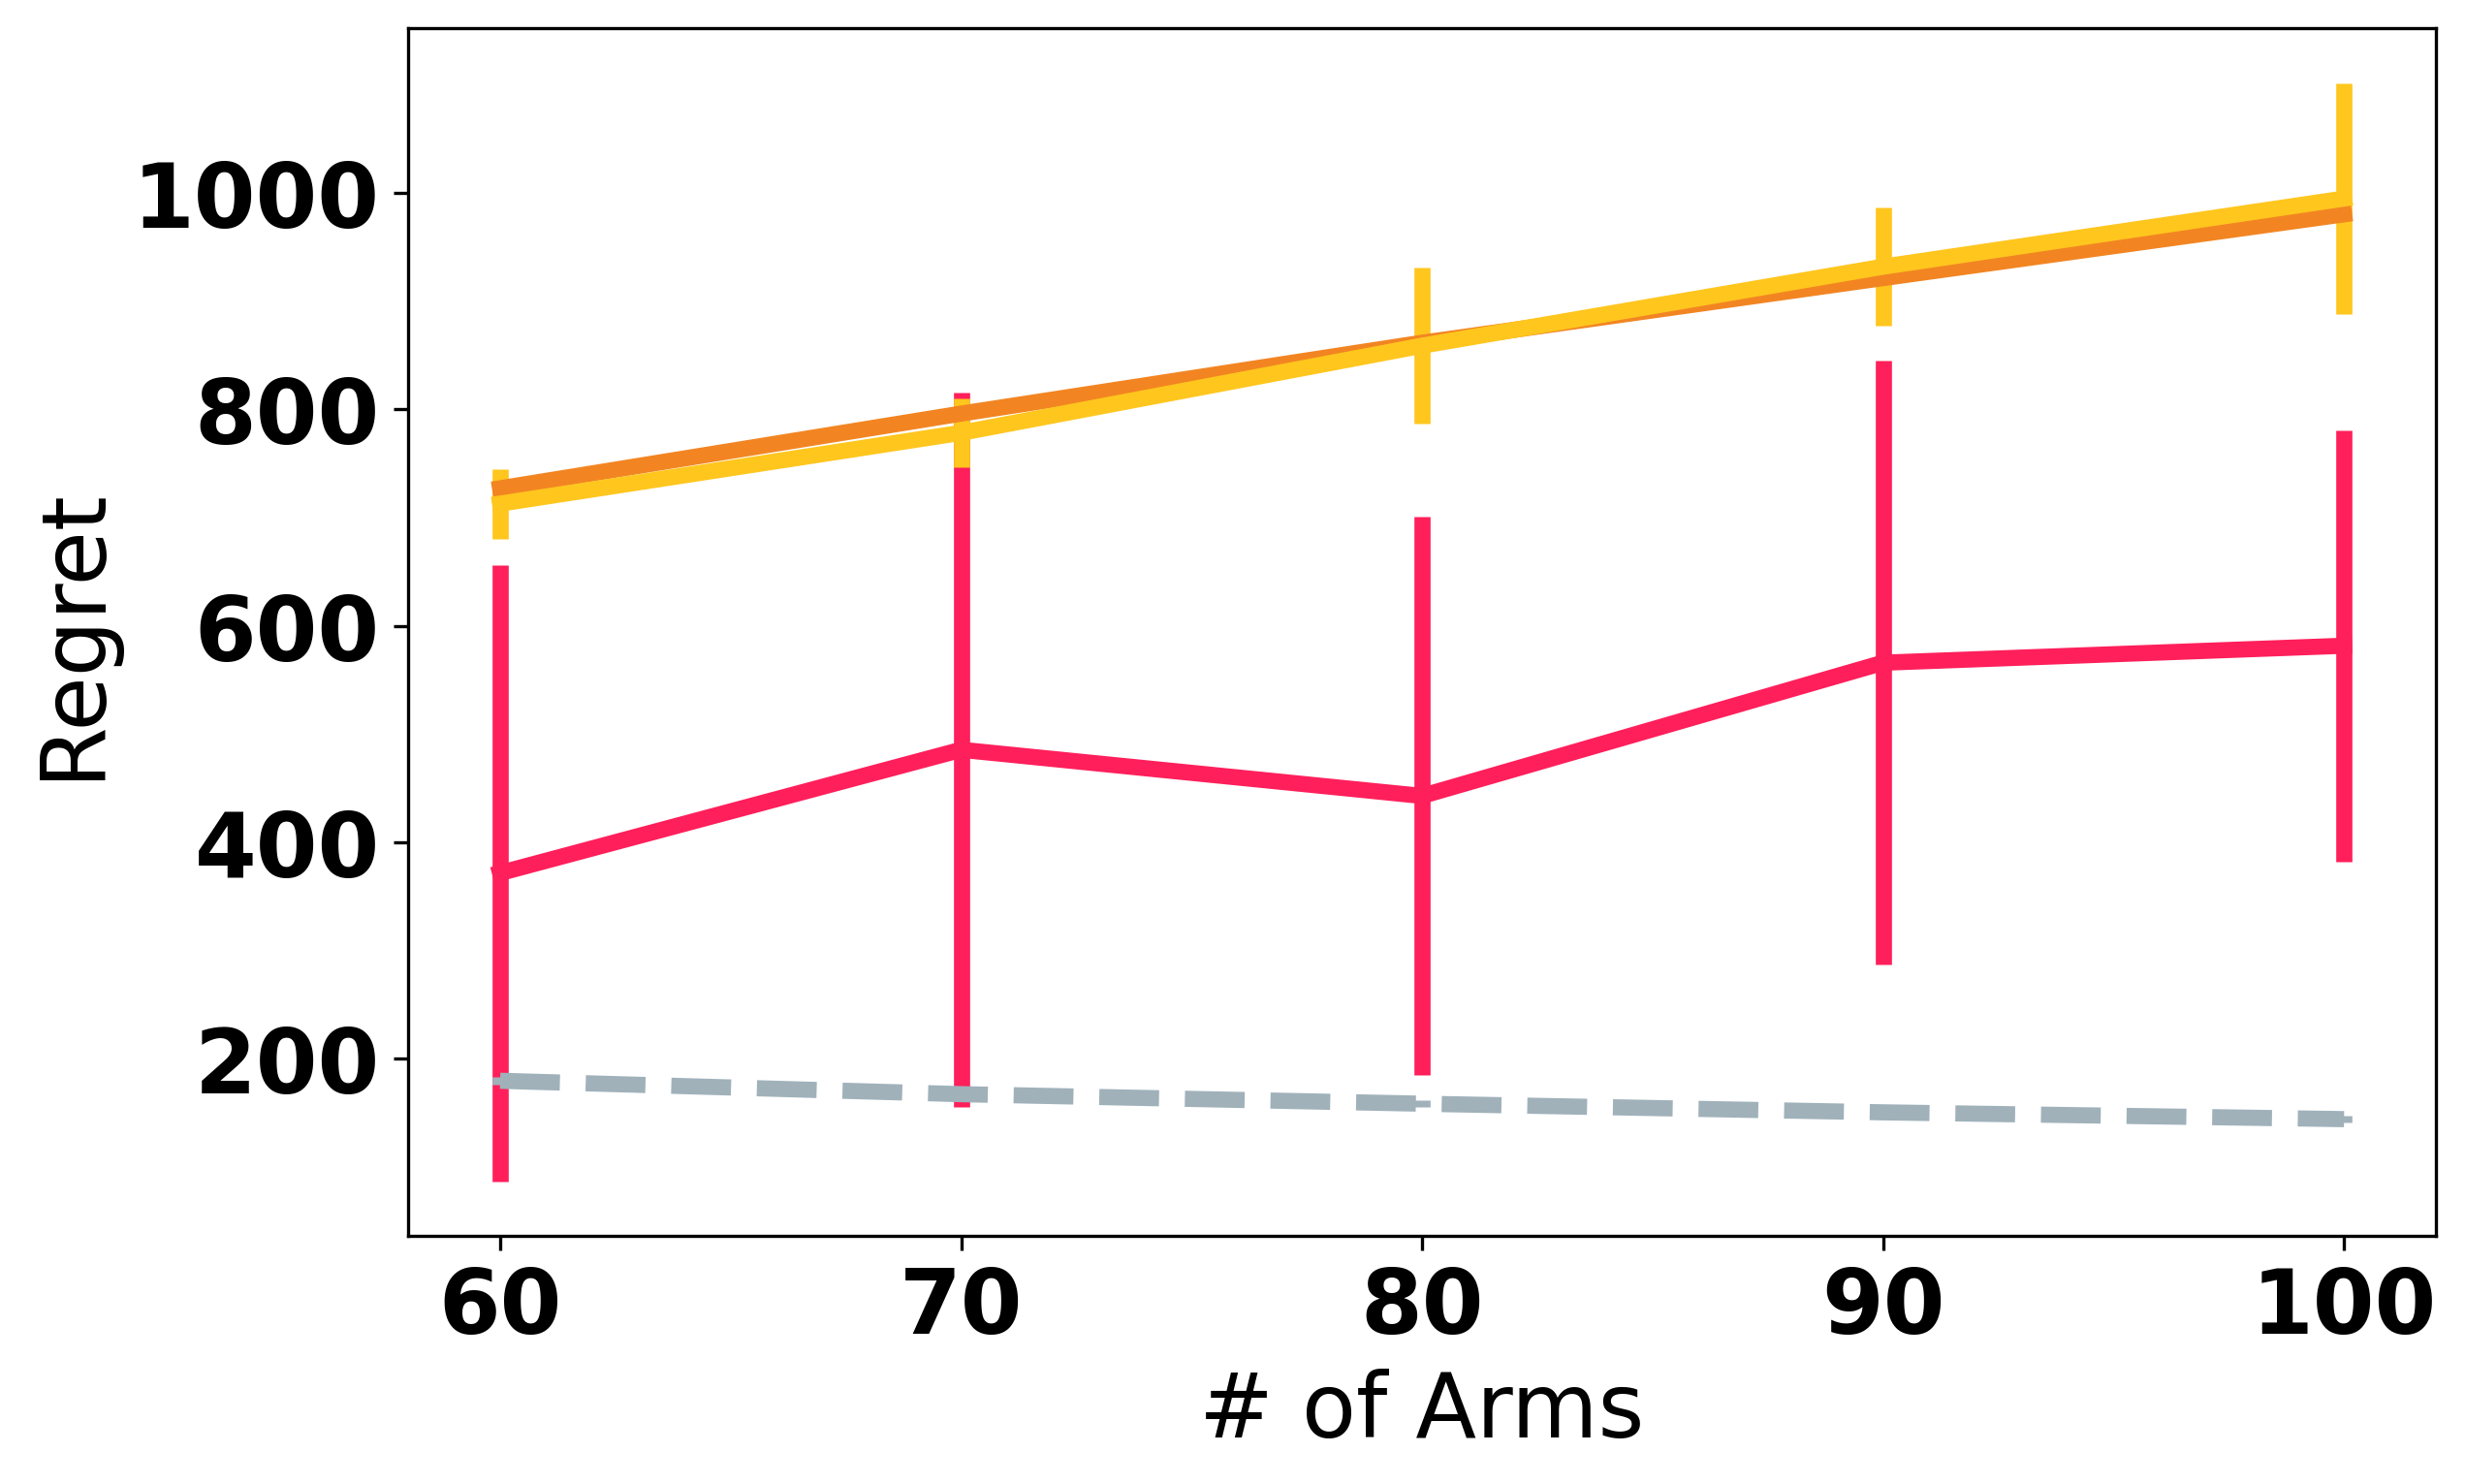

In [53]:
# Plot from loaded cache file
# HORIZON = 12000
X_b = np.arange(60,101,10)
# X_b = np.arange(3,8,1) # small
# title = f'{setting}: Horizon = {HORIZON}, {N_TASKS} tasks, and subset size = {OPT_SIZE}'
title = ''
xlabel, ylabel = '# of Arms', 'Regret'
regret_dict_b = pickle.load(open("results/cache_600_tasks/Adversarial_arms.p", "rb"))
# regret_dict_b = pickle.load(open("results/cache_600_tasks/Adversarial_arms.p", "rb"))
# plt.ylim([-5, 55])
utils.plot(X_b, regret_dict_b, title, xlabel, ylabel, **kwargs)

## Regret vs subset size

100%|██████████| 2/2 [00:00<00:00, 201.51it/s]

opt_indices = [2]
opt_indices = [3]


opt_indices = [0 2]
opt_indices = [0 2]
opt_indices = [1 2 3]
opt_indices = [0 2 4]
opt_indices = [0 1 2 3]opt_indices = [1 2 3 4]

opt_indices = [0 1 2 3 4]
opt_indices = [0 1 2 3 4]


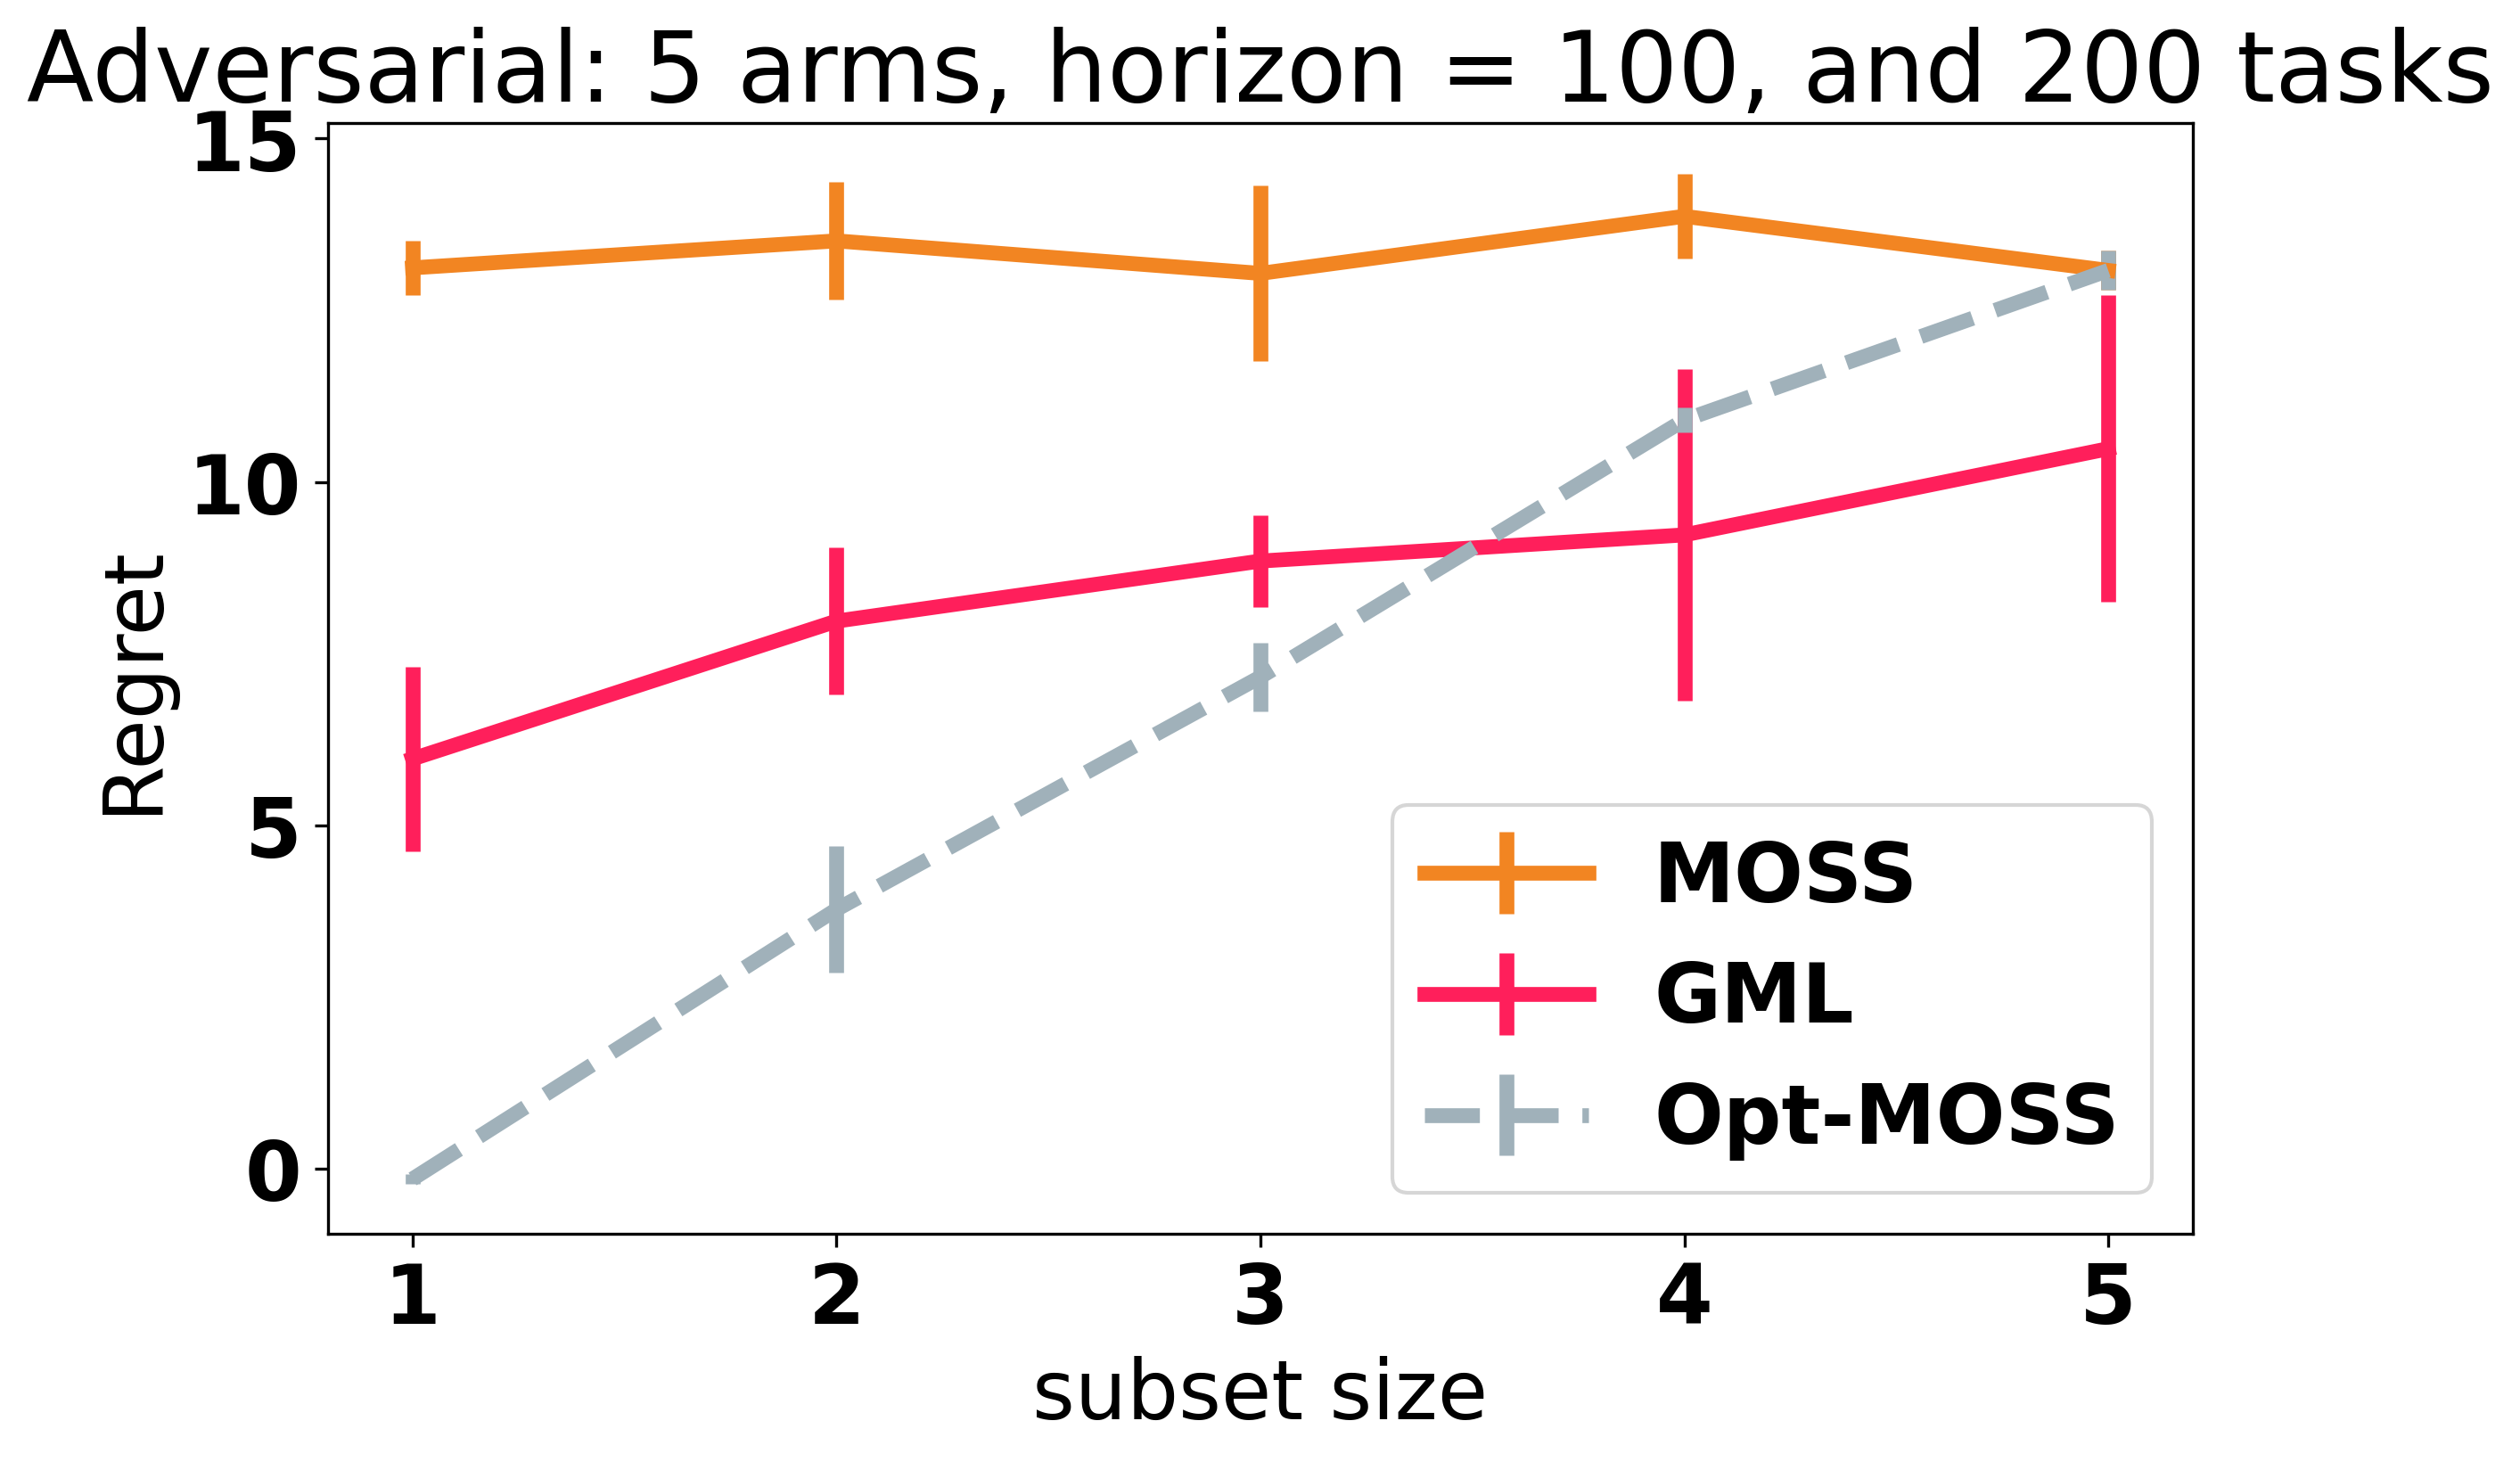

In [5]:
opt_size_list = np.arange(2,N_ARMS+1,1)
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = opt_size_list, **kwargs)
# pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
# regret_dict_h = pickle.load(open("results/subset.p", "rb"))
pass

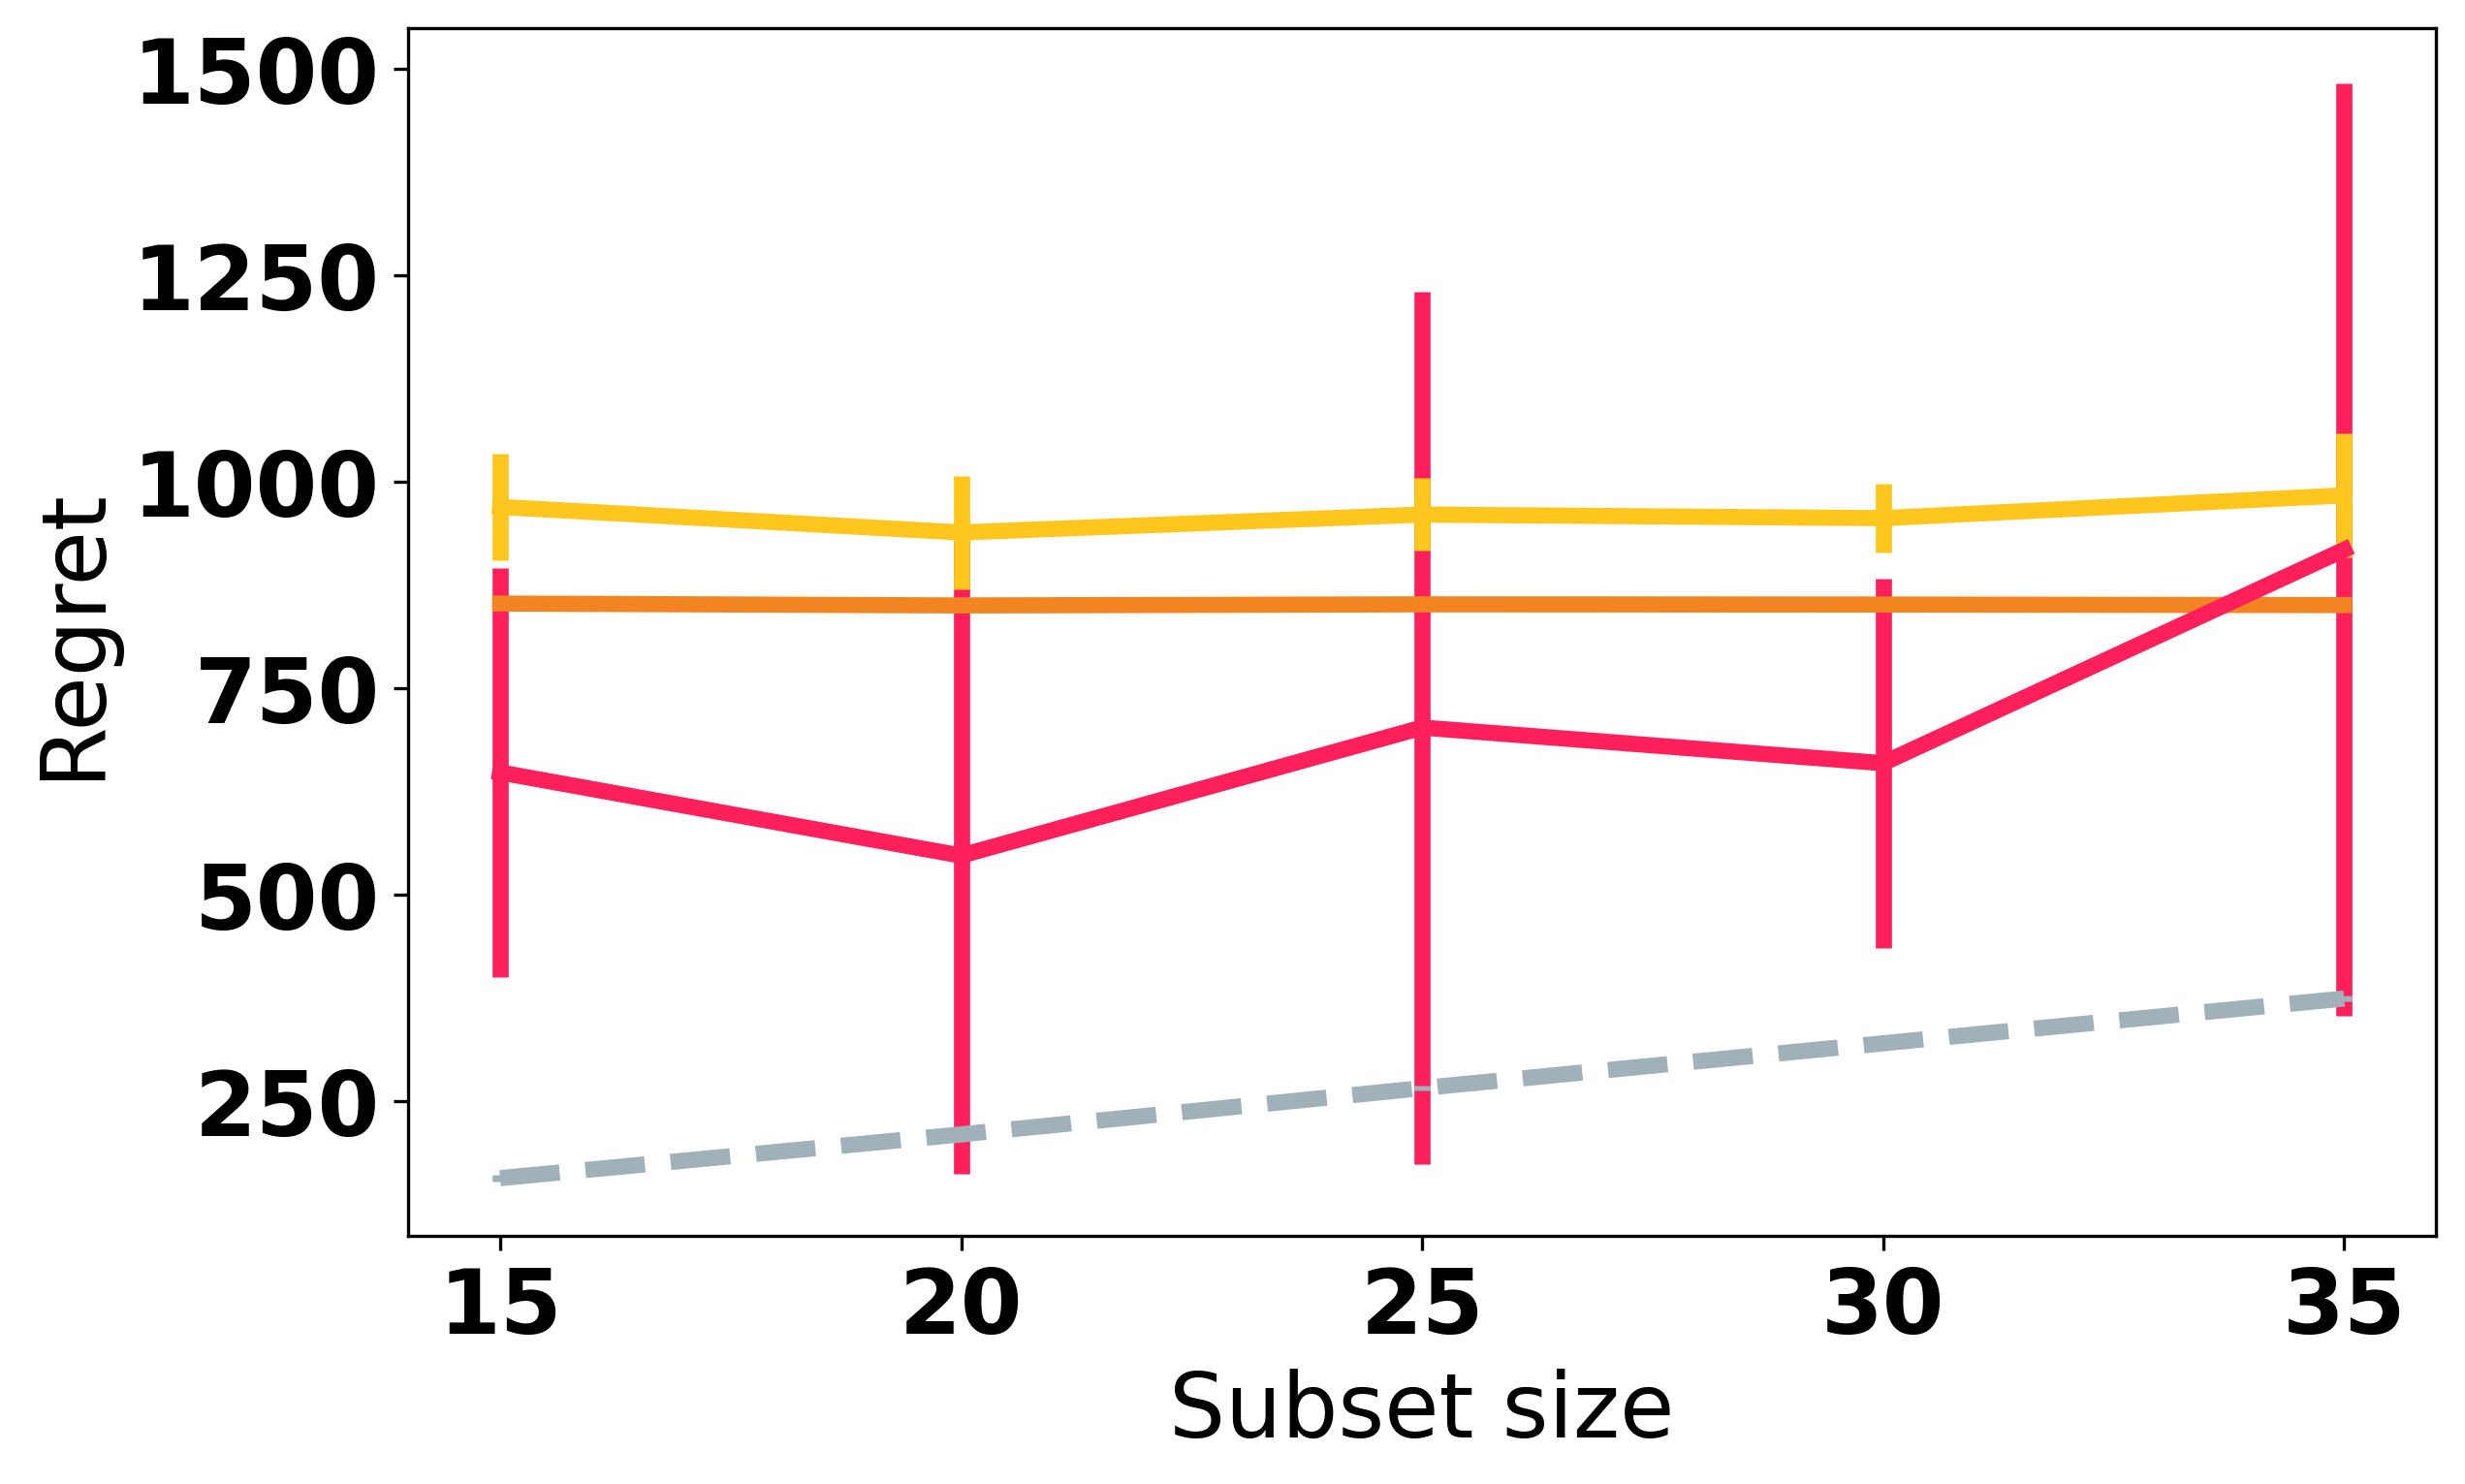

In [54]:
# Plot from loaded cache file
# title=f'{setting}: {N_ARMS} arms, horizon = {HORIZON}, {N_TASKS} tasks'
title = ''
xlabel, ylabel = 'Subset size', 'Regret'
# X_e = np.arange(2,6,1)
X_e = np.arange(15,36,5)
# regret_dict_e = pickle.load(open("results/Adversarial2_subset.p", "rb"))
regret_dict_e = pickle.load(open("results/cache_600_tasks/Adversarial_subset.p", "rb"))
utils.plot(X_e, regret_dict_e, title, xlabel, ylabel, **kwargs)

# Plotting legend code

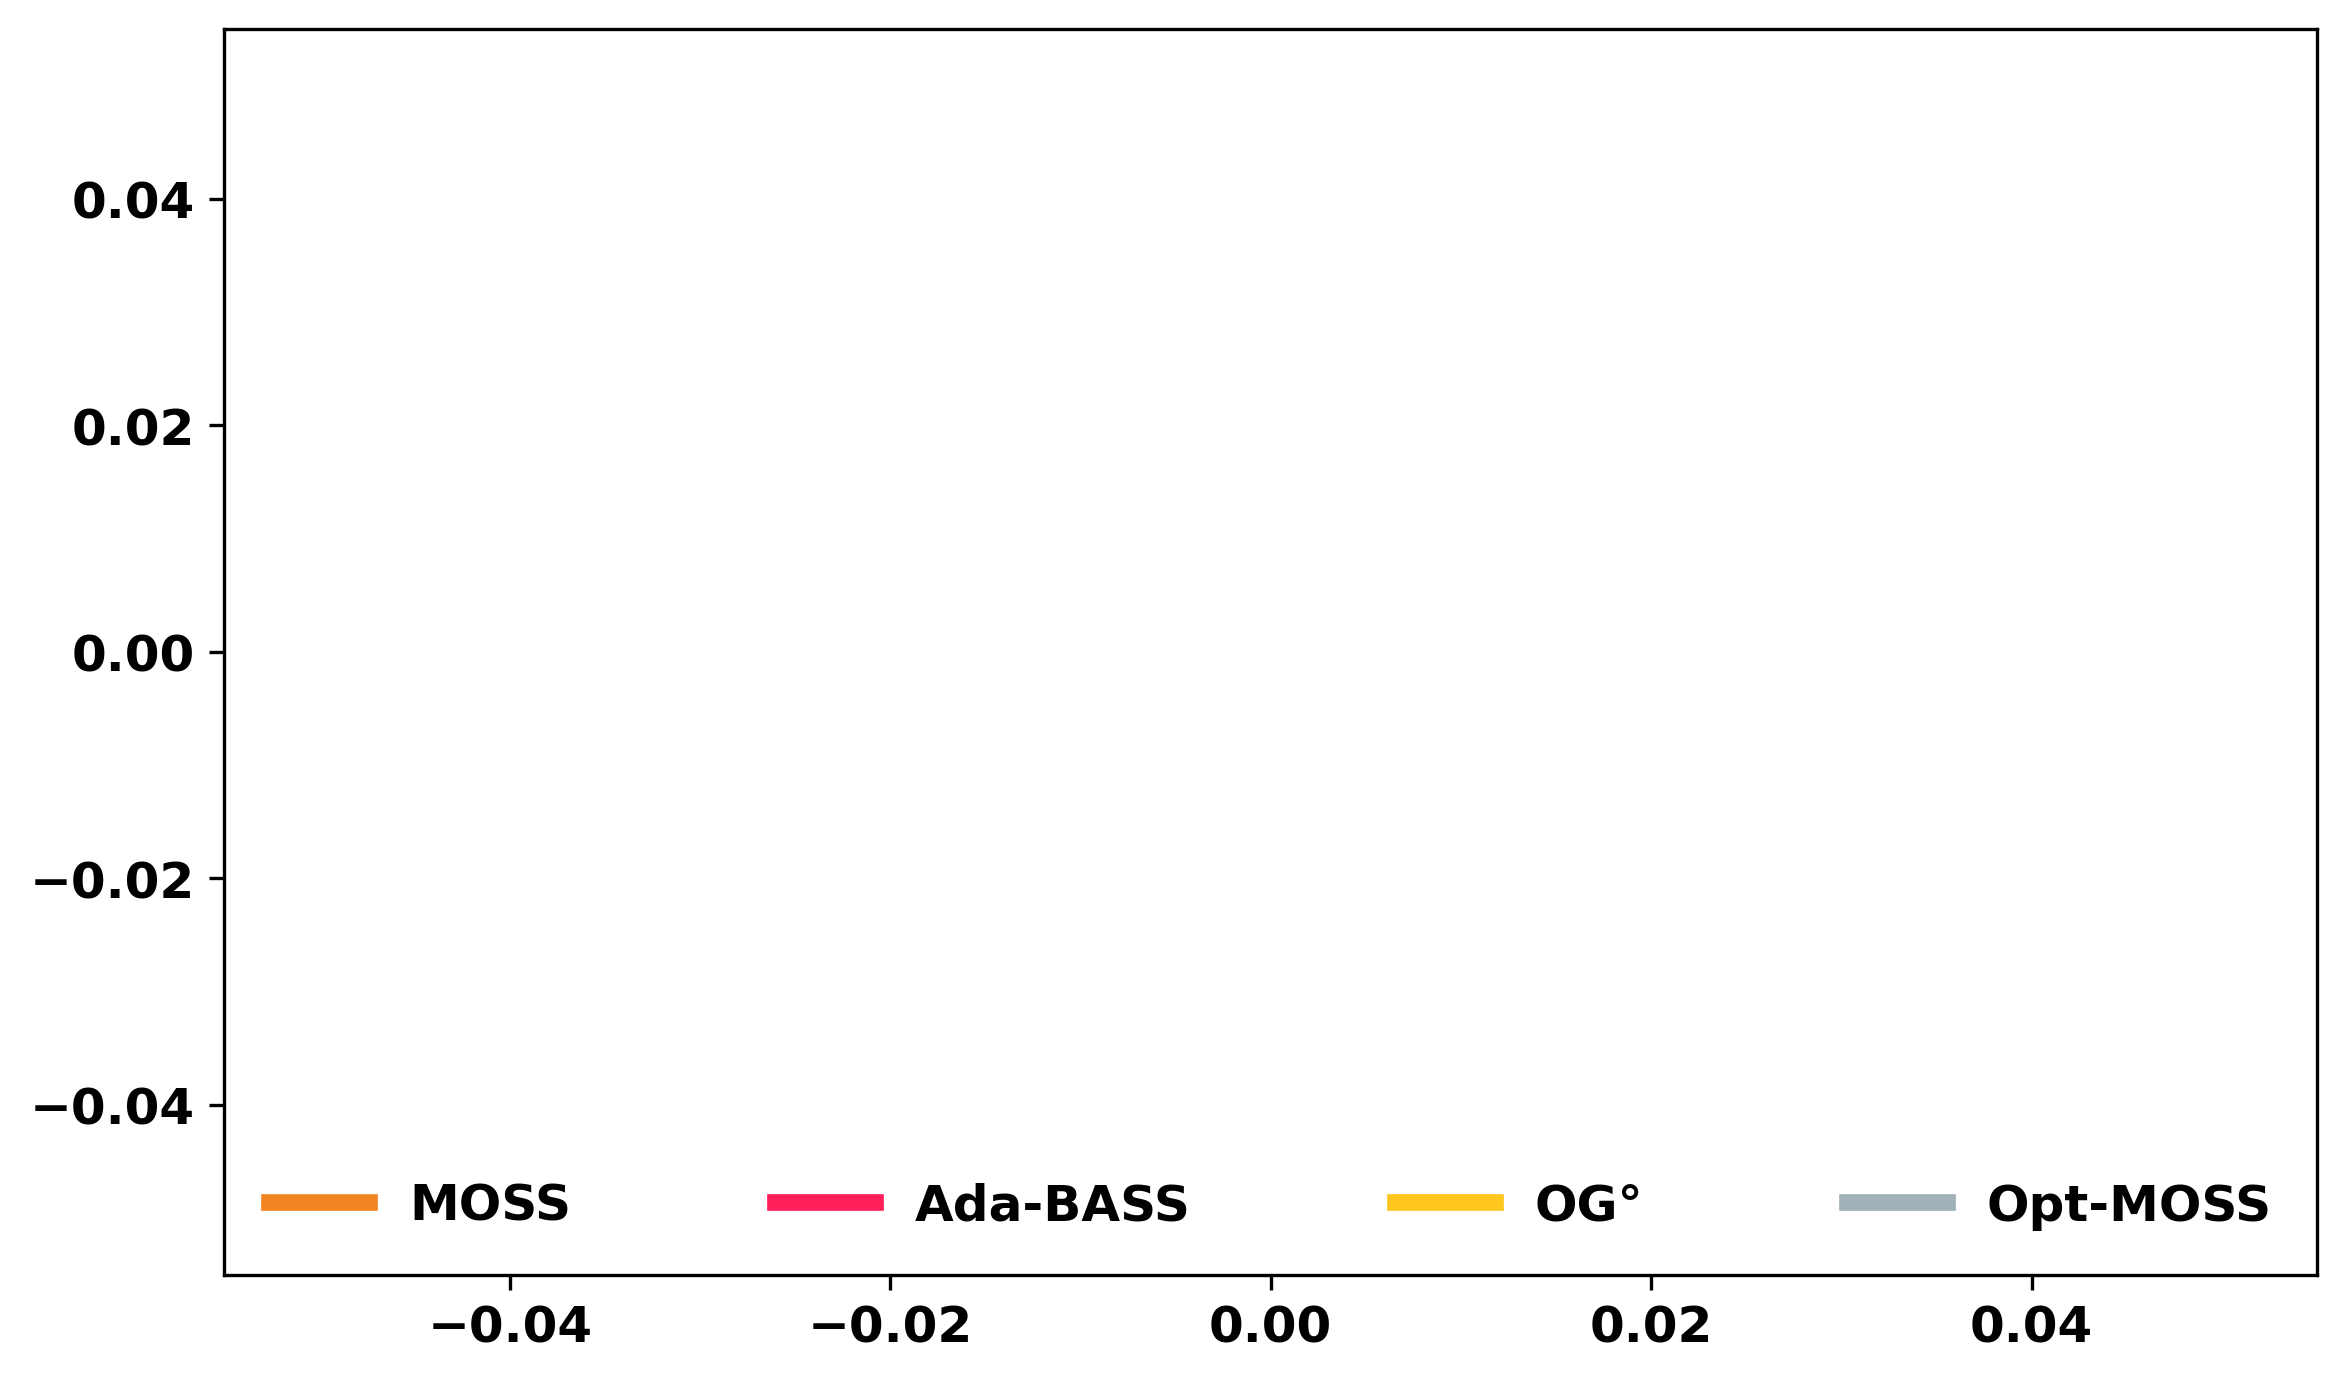

In [10]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]
# plt.rcParams['figure.figsize'] = [15, 5.5] # NIPS format: [9, 5.5]
labels = ["MOSS", "G-BASS", "OG°", "Opt-MOSS"]
# labels = ["MOSS", "EE", "G-BASS", "PMML", "OG°", "Opt-MOSS"]
colors = ["#F28522", "#FF1F5B", "#FFC61E", "#A0B1BA"]
# colors = ["#F28522", "#009ADE", "#FF1F5B", "#00CD6C", "#FFC61E", "#A0B1BA"]
linestyles = ["-", "-", "-", "-", "dashed"]
# linestyles = ["-", "-", "-", "-", "-", "dashed"]
f = lambda c,l: plt.plot([],[], color=c, ls=l, linewidth=4)[0]
handles = [f(colors[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, mode="expand", ncol=len(handles))

def export_legend(legend, filename="legend4.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()